# Computing set 1
## By Caspar van Eck, 12652857


In this project we simulate the viscous evolution of a thin accretion disk. The disk is assumed to be thin (in other words the scale-height H is much smaller than the radius R) and in Keplerian rotation, so that the radial drift velocity $v_R$ is very small compared to the orbital velocity.

We adopt the Shakura–Sunyaev prescription from the coursenotes for viscosity,

$\nu = \alpha\, c_s\, H,$

with $\alpha = 0.01$ (see coursenotes 6, chapter 10). The inner boundary is set to mimic the innermost stable circular orbit (ISCO) by enforcing a near-zero surface density (see coursenotes 5, chapter 7), while the outer boundary is maintained at a constant mass accretion rate, so we can observe the disk evolving toward the analytical steady-state solution. This setup allows us to check the disk conservation equations in a simplified manner by ignoring variations in scale-height and sound speed.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from disklab.natconst import *
from disklab.diskradial import DiskRadialModel

# Define physical parameters for the black hole accretor and disk boundaries
MBH = 5 * MS          # Black hole mass (5 times the solar mass)
R_in  = 0.1 * AU      # Inner radius of the disk
R_out = 1 * AU        # Outer radius of the disk

alpha_num = 0.01      # Viscosity parameter

# Initialize the disk radial model with the specified parameters
d = DiskRadialModel(
    mstar = MBH,
    rin   = R_in,
    rout  = R_out,     
    alpha = alpha_num,
)
d.make_disk_from_m_pl(mdisk=0.01*MBH)  # Create the disk with a given mass (1% of MBH)

### Viscosity Calculation and Comparison

We compute the disk’s viscosity using our model and compare the computed profile with the analytical value predicted by the $\alpha$ prescription:

$\nu_{\text{expected}} = \alpha\, \frac{c_s^2}{\Omega_K},$

where  $c_s $ is the sound speed and  $\Omega_K$  is the Keplerian angular velocity. This step verifies that DISKLAB computes the correct viscosity (with d.nu) as expected from theory (see coursenotes 6, chapter 10). We calculate the relative difference and plot both profiles.

Maximum relative difference: 2.41e-16


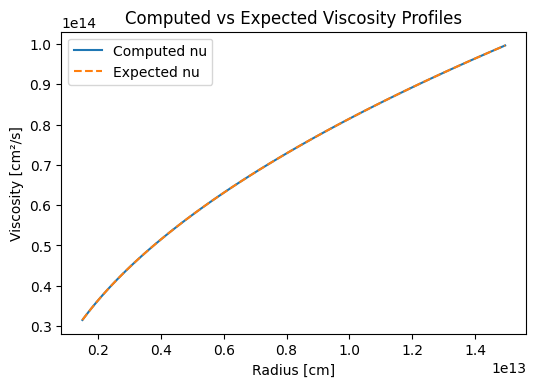

In [15]:
# Compute the viscosity using the model
d.compute_nu()

# Calculate the expected viscosity from the alpha prescription
nu_expected = d.alpha * d.cs**2 / d.omk

# Compute the relative difference between computed and expected viscosity (+ 1e-20 to avoid division by zero)
rel_diff = np.abs(d.nu - nu_expected) / (np.abs(nu_expected) + 1e-20)
max_diff = np.max(rel_diff)

print(f"Maximum relative difference: {max_diff:.2e}")

# Plotting the computed and expected viscosity profiles
plt.figure(dpi=100)
plt.plot(d.r, d.nu, label='Computed nu')
plt.plot(d.r, nu_expected, '--', label='Expected nu')
plt.xlabel('Radius [cm]')
plt.ylabel('Viscosity [cm²/s]')
plt.title('Computed vs Expected Viscosity Profiles')
plt.legend()
plt.show()

### Time Evolution of the Surface Density

We then simulate the time evolution of the disk’s surface density  $\Sigma$. The simulation evolves the disk from the initial state toward a steady state. The time range is chosen from  $t_{\text{start}} = 10^{-3}$  s to  $t_{\text{end}} = 2\times10^{13}$  s, 635 thousand years, with 100 logarithmically spaced timesteps. The log spacing allows us to see both early, small scale behavior and long-term evolution.

The timescale is chosen based on when the disk reaches a steady state. We decide this is when the maximum relative difference between the numerical and analytical surface density is as small as possible. This makes sure that the numerical solution has converged to the steady-state distribution expected from the conservation equations (see coursenotes 5, chapter 7).

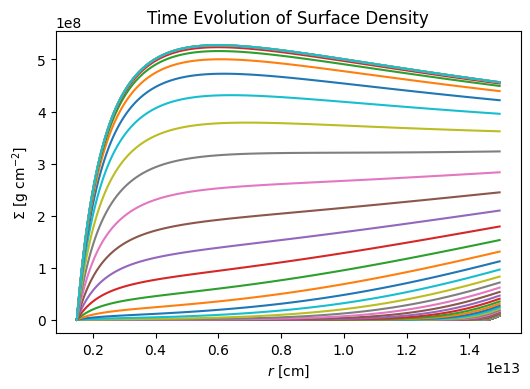

In [16]:
t_start = 1e-3
t_end = 2e13
ntime = 100
# Generate logarithmically spaced time steps to capture both transient and steady behavior
time_steps = t_end ** (np.linspace(0, 1, ntime + 1))
fig, ax = plt.subplots(dpi=100)
for i in range(1, ntime + 1):
    dt = time_steps[i] - time_steps[i - 1]
    d.compute_nu() 
    d.sigma = d.get_viscous_evolution_next_timestep(
        dt,
        sigma_innerbc=1e-30,   # Near-zero surface density at the inner boundary
        alphamodel=False,
        mdot_outerbc=0.01 * MS / year  # Constant mass accretion rate at the outer boundary
    )
    ax.plot(d.r, d.sigma, label=f'Time = {time_steps[i]:.1e} s')

ax.set_xlabel(r'$r$ [cm]')
ax.set_ylabel(r'$\Sigma$ [g cm$^{-2}$]')
ax.set_title('Time Evolution of Surface Density')
plt.show()

### Comparison with the Analytical Solution

After evolving the disk over the time interval, we compare the final numerical surface density profile with the analytical solution derived from the conservation equations:

$\Sigma_{\text{analytic}} = \frac{\dot{M}}{3\pi\,\nu} \left[ 1 - \left(\frac{R_{\text{in}}}{R}\right)^{1/2} \right],$

as derived in coursenotes 5, chapter 7. We compute the relative difference between the numerical and analytical profiles. A minimized maximum relative difference indicates that the disk has reached a steady state.

Maximum relative difference: 5.78e-03


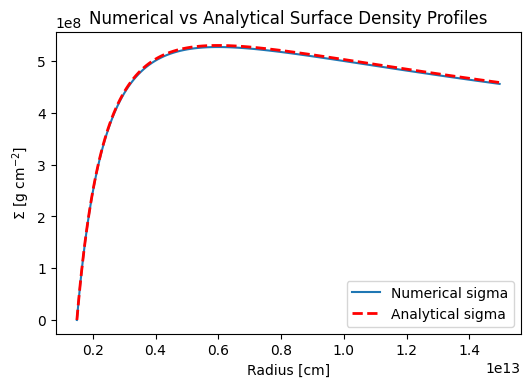

In [17]:
# Calculate the analytical solution for surface density
mdot = 0.01 * MS / year
sigma_analytic = mdot / (3 * np.pi * d.nu) * (1 - np.sqrt(R_in / d.r))

# Compute the relative difference to quantitatively verify convergence (+ 1e-20 to avoid division by zero)
rel_diff_sigma = np.abs(d.sigma - sigma_analytic) / (np.abs(sigma_analytic) + 1e-20)
max_diff_sigma = np.max(rel_diff_sigma)

print(f"Maximum relative difference: {max_diff_sigma:.2e}")

# Plot the numerical and analytical surface density profiles
plt.figure(dpi=100)
plt.plot(d.r, d.sigma, label='Numerical sigma')
plt.plot(d.r, sigma_analytic, '--', color='red', lw=2, label='Analytical sigma')
plt.xlabel('Radius [cm]')
plt.ylabel(r'$\Sigma$ [g cm$^{-2}$]')
plt.title('Numerical vs Analytical Surface Density Profiles')
plt.legend()
plt.show()

### Discussion and Conclusion

The computed viscosity profile closely matches the analytical expectation from the viscosity prescription. The evolution of the surface density  $\Sigma$  shows clear convergence toward the analytical steady-state solution.

The chosen time range (from $10^{-3}$ s to $2\times10^{13}$ s) and the log spacing of timesteps were chosen to best show the ''filling up'' behavior and evolution into a steady state. By calculating the maximum relative difference between the numerical and analytical profiles, we showed that the simulation had reached a steady state. This quantitative verification confirms that our implicit solver and boundary condition choices (including setting $\Sigma$ to near 0 at the inner boundary and a constant $\dot{M}$ at the outer boundary) are effective.

The results show that the numerical solution converges to the analytically derived steady-state profile. This verifies that the mechanism of viscous angular momentum transport, implemented using $\alpha$, is redistributing angular momentum, allowing the inner disk material to accrete inward. These findings align with the theory from coursenotes 6 and coursenotes 7.

PS: Timescale was given in seconds to simplify minimization and because cgs units were required. 'mdot_outerbc' was chosen in discussion with the TAs.